Загрузка датафрейма и предварительная очистка данных 

In [3]:
import pandas as pd
df=pd.read_csv('data.csv',sep=';',encoding='utf-8')
df.columns
df.drop(['federal_district','okato','region_code','name'],axis=1,inplace=True)


2.1 Университеты с более высоким показателем оплаты труда ППС (e5) показывают лучшие результаты по обеспеченности кадрами с учеными степенями (e8)

Коэффициент корреляции: 0.0102
Сила связи между показателями: слабая


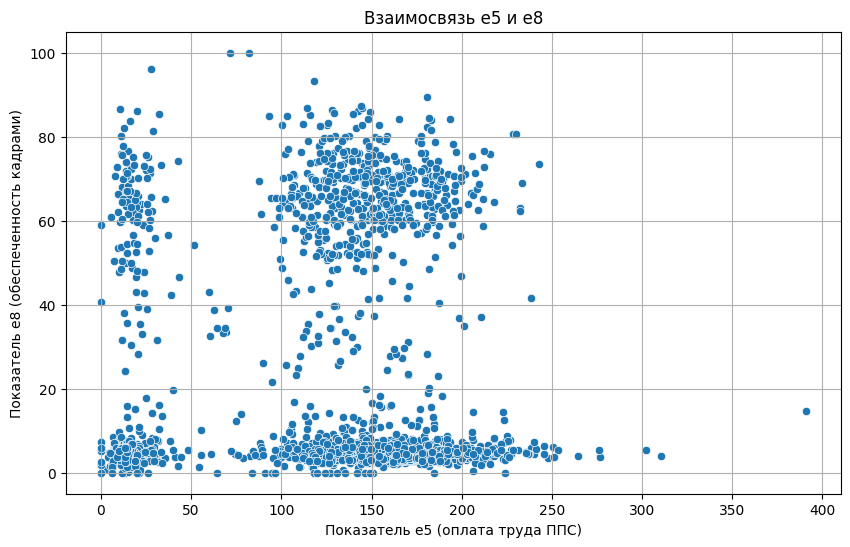

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Проверка корреляции
correlation = df['e5'].corr(df['e8'])
print(f'Коэффициент корреляции: {correlation:.4f}')



# Интерпретация силы связи
if abs(correlation) < 0.3:
    strength = "слабая"
elif abs(correlation) < 0.7:
    strength = "умеренная"
else:
    strength = "сильная"

print(f"Сила связи между показателями: {strength}")

# Визуализация взаимосвязи
plt.figure(figsize=(10, 6))
sns.scatterplot(x='e5', y='e8', data=df)
plt.title('Взаимосвязь e5 и e8')
plt.xlabel('Показатель e5 (оплата труда ППС)')
plt.ylabel('Показатель e8 (обеспеченность кадрами)')
plt.grid(True)
plt.savefig('e5e8.png')
plt.show()


2.2 Финансовые ресурсы вуза выраженные в доходах (total_income) оказывают прямое влияние на показатели научной продуктивности, измеряемые через количество публикаций в ведущих 

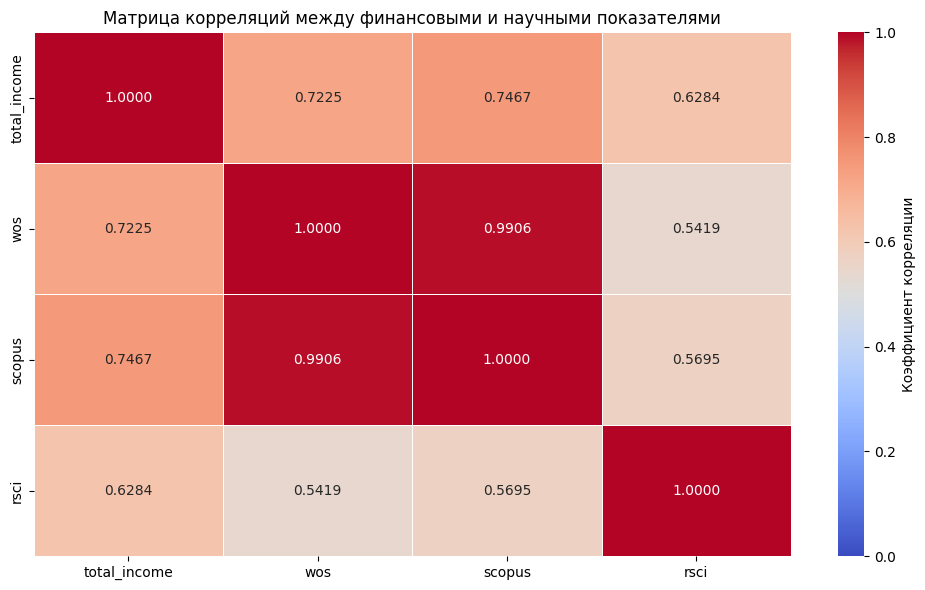

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Группируем данные по id университета  и считаем средние значения 
grouped_data = df.groupby('id').agg({
    'total_income': 'mean',
    'wos': 'mean',
    'scopus': 'mean',
    'rsci': 'mean'
}).reset_index()


# Анализ корреляций
correlations = grouped_data[['total_income', 'wos', 'scopus', 'rsci']].corr()

# Визуализация
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlations,
    annot=True,
    cmap='coolwarm',
    fmt=".4f",
    linewidths=0.5,
    cbar_kws={'label': 'Коэффициент корреляции'},
    vmin=0,
    vmax=1
)
plt.title('Матрица корреляций между финансовыми и научными показателями')
plt.tight_layout()
plt.savefig('total_income.png')
plt.show()


2.3 Чем выше общий доход вуза, тем больше количество обучающихся в нём студентов.

C:\Users\vyacheslav.zakhvatov\AppData\Local\Temp\ipykernel_10304\2859425343.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('income_group')['pk'].describe()


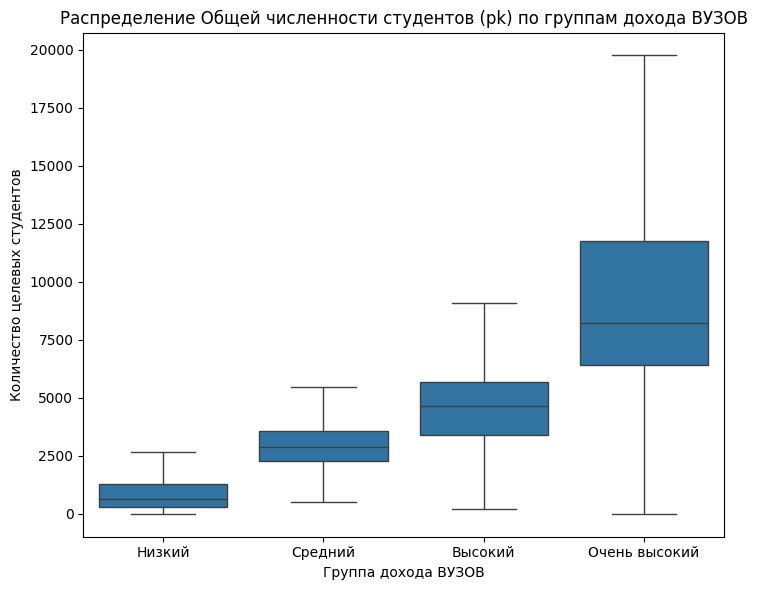

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем группы доходов вузов (разбиваем на квантили )
df['income_group'] = pd.qcut(
    df['total_income'], 
    q=4, 
    labels=['Низкий', 'Средний', 'Высокий', 'Очень высокий']
)


# Описательная статистика по группам для pk
group_stats = df.groupby('income_group')['pk'].describe()

# Визуализация распределения pk по группам
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(
    data=df,
    x='income_group',
    y='pk',
    order=['Низкий', 'Средний', 'Высокий', 'Очень высокий'],
    showfliers=False
)
plt.title('Распределение Общей численности студентов (pk) по группам дохода ВУЗОВ')
plt.xlabel('Группа дохода ВУЗОВ')
plt.ylabel('Количество целевых студентов')

plt.tight_layout()
plt.savefig('pk.png')
plt.show()

# Сохраняем таблицу в HTML
with open('stats_table.html', 'w') as f:
    f.write(group_stats.to_html())

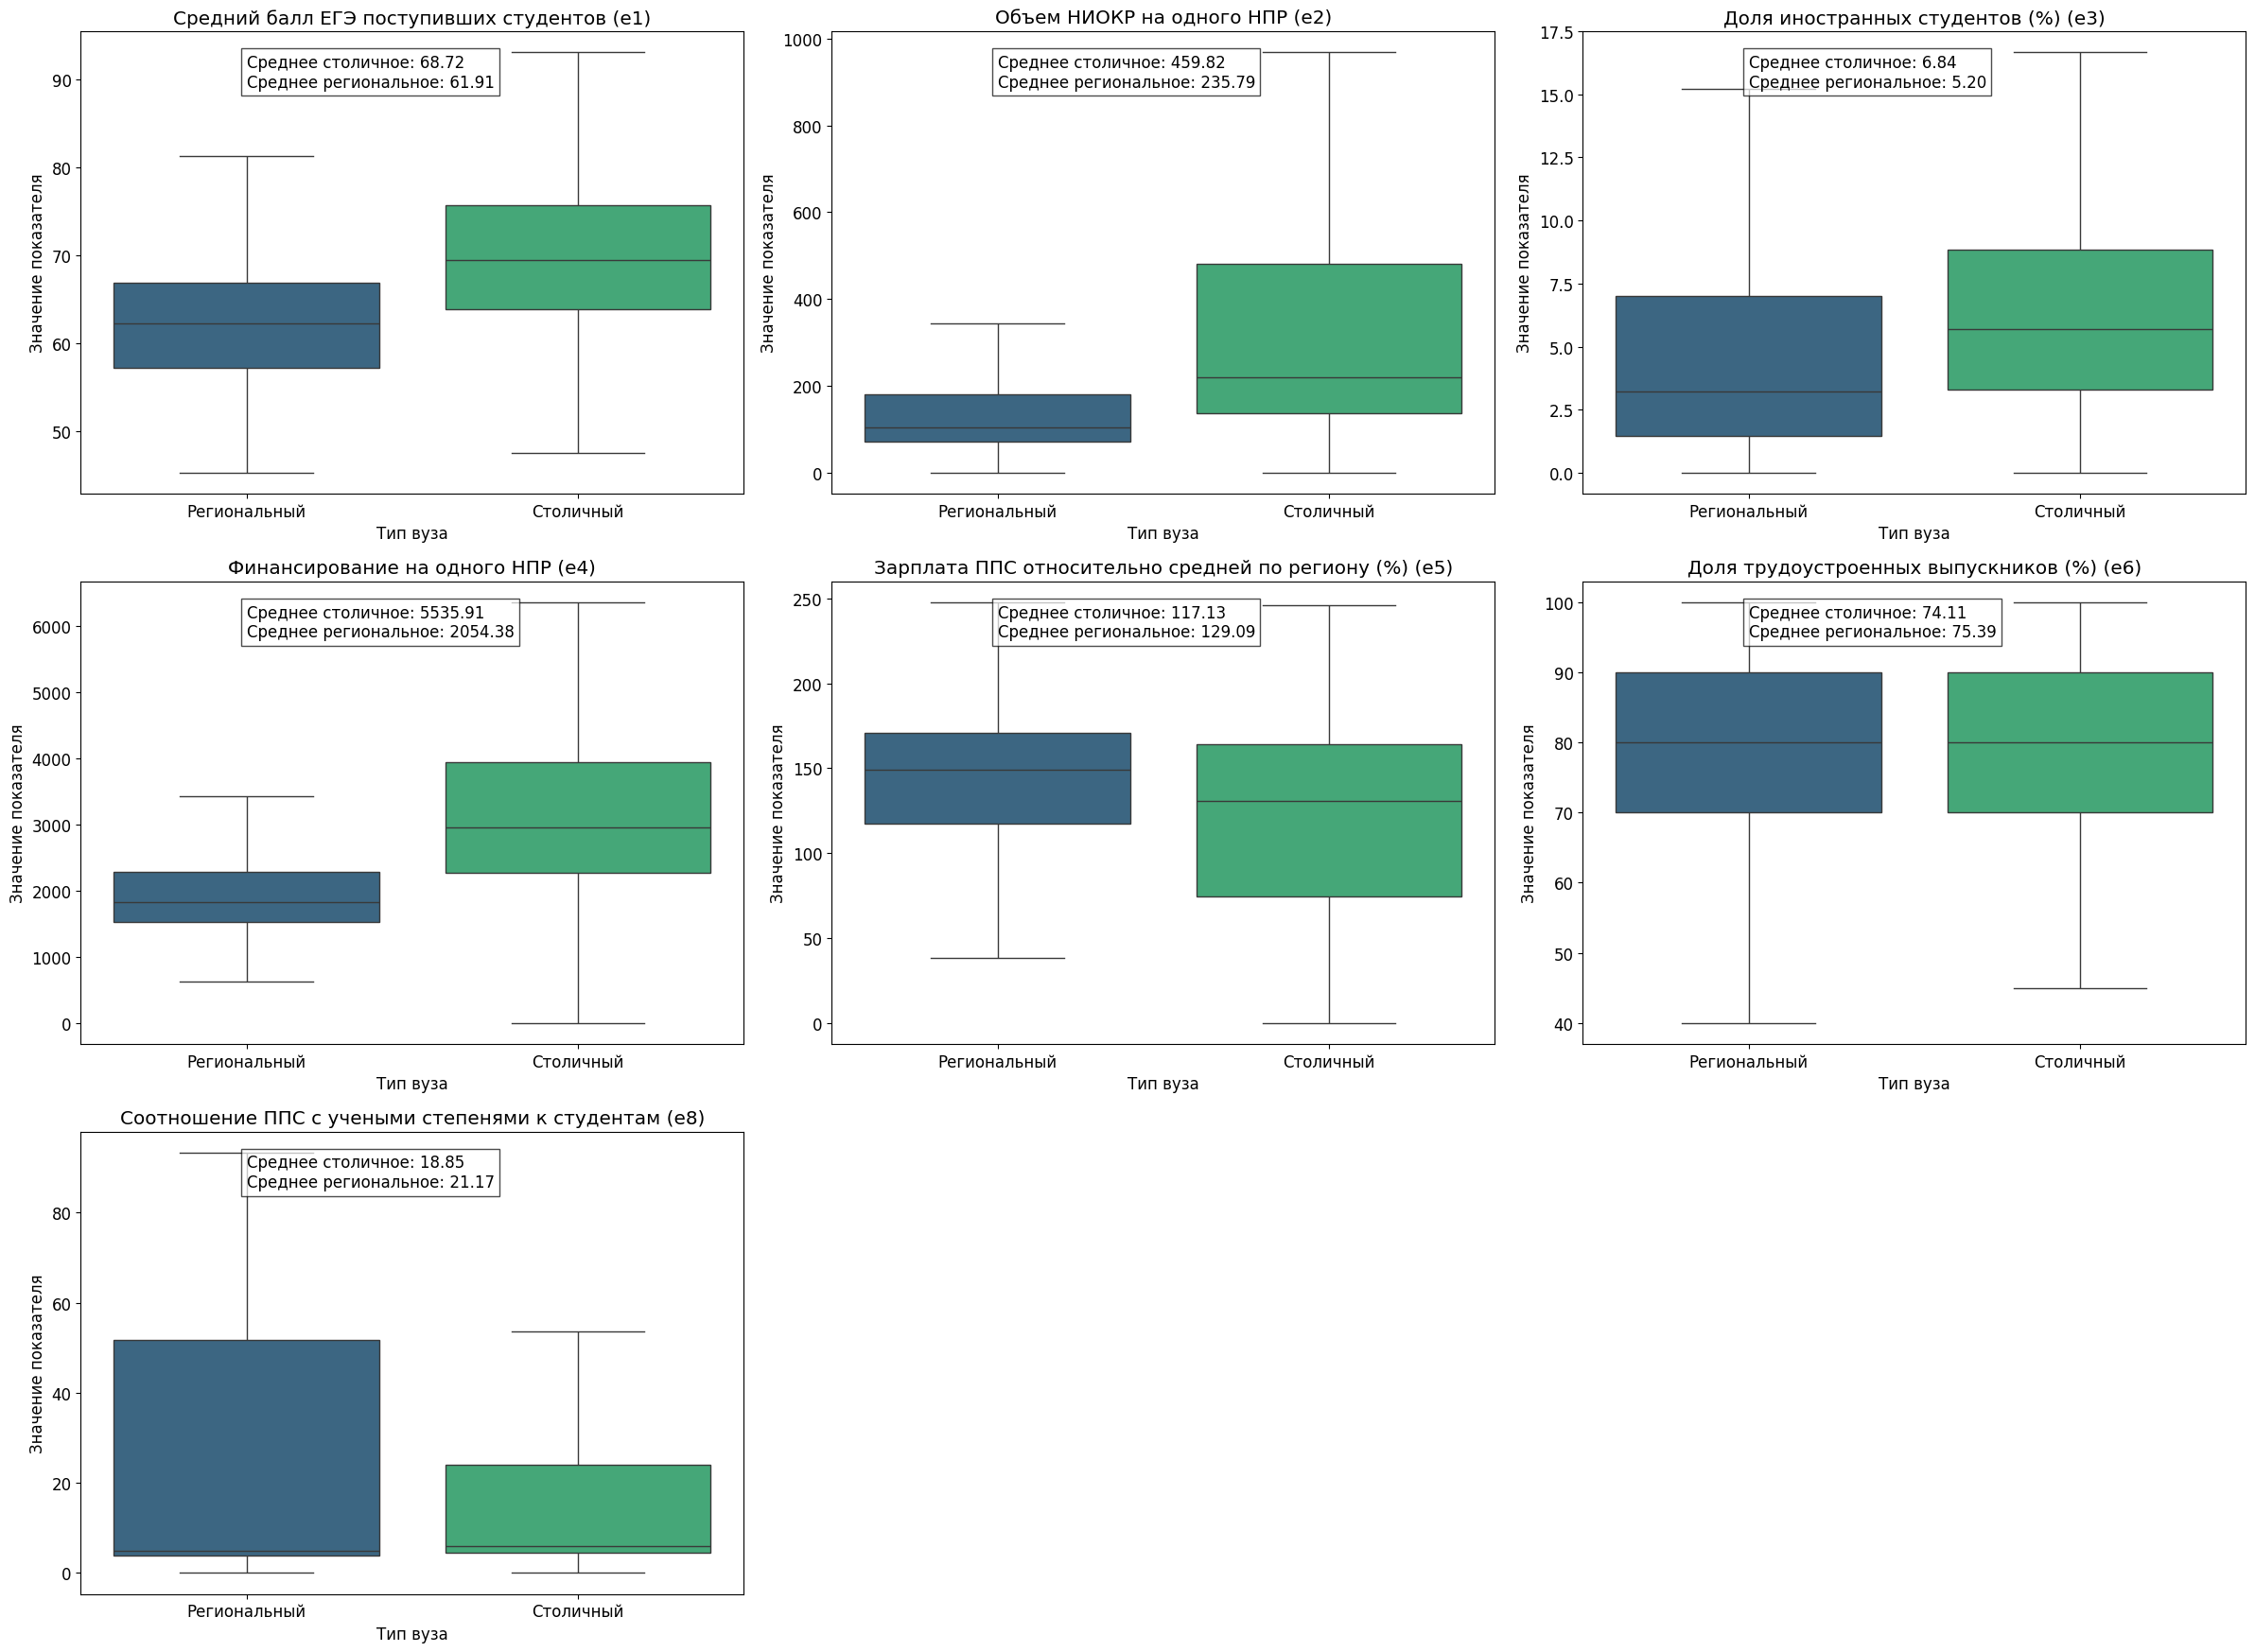

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем признак "тип вуза"
df['type'] = np.where(
    df['region_name'].str.contains('Москва|Московская область|Санкт-Петербург|Ленинградская область'),
    'Столичный',
    'Региональный'
)

# Предварительная обработка данных
df_clean = df.dropna(subset=['type', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e8'])

# Словарь с названиями показателей
metric_names = {
    'e1': 'Средний балл ЕГЭ поступивших студентов (e1)',
    'e2': 'Объем НИОКР на одного НПР (e2)',
    'e3': 'Доля иностранных студентов (%) (e3)',
    'e4': 'Финансирование на одного НПР (e4)',
    'e5': 'Зарплата ППС относительно средней по региону (%) (e5)',
    'e6': 'Доля трудоустроенных выпускников (%) (e6)',
    'e8': 'Соотношение ППС с учеными степенями к студентам (e8)'
}

# Настройка стиля графиков
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(16, 12))

# Создание панели графиков
for i, metric in enumerate(metric_names.keys(), 1):
    plt.subplot(3, 3, i)
    
    # Боксплот без выбросов
    sns.boxplot(
        x='type',
        y=metric,
        hue='type',  # Добавляем hue
        data=df_clean,
        palette='viridis',
        showfliers=False,  # Отключаем отображение выбросов
        legend=False  # Убираем легенду
    )
    
    # Добавление сводной статистики
    plt.title(f'{metric_names[metric]}')
    plt.xlabel('Тип вуза')
    plt.ylabel('Значение показателя')
    
    # Расчет средних значений
    mean_capital = df_clean[df_clean['type'] == 'Столичный'][metric].mean()
    mean_regional = df_clean[df_clean['type'] == 'Региональный'][metric].mean()
    
    # Добавление аннотаций
    plt.text(
        0.25, 
        0.88, 
        f'Среднее столичное: {mean_capital:.2f}\n'
        f'Среднее региональное: {mean_regional:.2f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7)
    )

plt.tight_layout(rect=(0, 0.03, 1.5, 1.5))
plt.savefig('all.png',bbox_inches='tight')
plt.show()
